<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/Multimodal_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nowrinjahan","key":"d1ec15a71452182fae5fb36e49423992"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
!kaggle datasets list -s "ovarian cancer"

ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2920         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3571         49  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1652         39  1.0          

In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


In [ ]:
# Define Dataset Paths and Classes
# --------------------------
IMG_SIZE = 224
DATASET_PATH = "OvarianCancer"  # Image Dataset path
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}


In [ ]:
# Load Image Data
# --------------------------
X_images, y_labels = [], []

for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)

    if not os.path.exists(class_path):
        continue  # Skip if folder doesn't exist

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip unreadable images

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.keras.applications.vgg19.preprocess_input(img)  # Preprocess for VGG19
        X_images.append(img)
        y_labels.append(class_mapping[class_name])  # Assign label

X_images = np.array(X_images)
y_labels = to_categorical(y_labels, num_classes=len(classes))  # One-hot encode labels


In [ ]:
# Load and Preprocess Tabular Data
# --------------------------
df = pd.read_csv("Ovarian_patient_data.csv")  # Replace with your actual CSV file path
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
features = ['age', 'ca125', 'cancerstage', 'bmi']  # Use relevant features
df = df.dropna(subset=features).reset_index(drop=True)
df = df.iloc[:len(X_images)]  # Align tabular data with image data

In [ ]:
# Normalize the tabular data
scaler = StandardScaler()
X_tabular = scaler.fit_transform(df[features].values)


In [ ]:
# --------------------------
# Train-test split
# --------------------------
X_train_img, X_test_img, X_train_tab, X_test_tab, y_train, y_test = train_test_split(
    X_images, X_tabular, y_labels, test_size=0.2, random_state=42
)


In [ ]:
# --------------------------
# Define the Image Model (VGG19)
# --------------------------
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze all layers of VGG19
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG19
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)



In [ ]:
# --------------------------
# Define the Tabular Model
# --------------------------
tab_input = tf.keras.Input(shape=(X_tabular.shape[1],), name="tabular_input")
y = Dense(64, activation="relu")(tab_input)
y = Dense(32, activation="relu")(y)

# --------------------------
# Combine Image and Tabular Models
# --------------------------
combined = tf.keras.layers.concatenate([x, y])
z = Dense(64, activation="relu")(combined)
output = Dense(len(classes), activation="softmax")(z)


In [ ]:
# --------------------------
# Compile the Model
# --------------------------
model = Model(inputs=[base_model.input, tab_input], outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
# --------------------------
# Callbacks
# --------------------------
lr_scheduler = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint("best_model_multimodal.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

# --------------------------
# Data Augmentation (For Image Data)
# --------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True
)

In [ ]:
# Train the model
history = model.fit(
    [X_train_img, X_train_tab],
    y_train,
    validation_data=([X_test_img, X_test_tab], y_test),
    epochs=20,  # Adjust the number of epochs
    batch_size=8,  # Batch size (adjust as needed)
    verbose=1,
    callbacks=[lr_scheduler, checkpoint]
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5080 - loss: 1.2359
Epoch 1: val_accuracy improved from 0.61000 to 0.62000, saving model to best_model_multimodal.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 357s 7s/step - accuracy: 0.5084 - loss: 1.2345 - val_accuracy: 0.6200 - val_loss: 1.0230 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5294 - loss: 1.1596
Epoch 2: val_accuracy improved from 0.62000 to 0.64000, saving model to best_model_multimodal.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 351s 7s/step - accuracy: 0.5298 - loss: 1.1586 - val_accuracy: 0.6400 - val_loss: 1.0172 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5660 - loss: 1.0732
Epoch 3: val_accuracy improved from 0.64000 to 0.65000, saving model to best_model_multimodal.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 342s 7s/step - accuracy: 0.5656 - loss: 1.0746 - val_accuracy: 0.6500 - val_loss: 0.9957 - learning_rate: 1.0000e-04
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5419 - loss: 1.1130
Epoch 4: val_accuracy did not improve from 0.65000
50/50 ━━━━━━━━━━━━━━━━━━━━ 342s 7s/step - accuracy: 0.5423 - loss: 1.1123 - val_accuracy: 0.6400 - val_loss: 0.9833 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6034 - loss: 1.0076
Epoch 5: val_accuracy did not improve from 0.65000
50/50 ━━━━━━━━━━━━━━━━━━━━ 453s 8s/step - accuracy: 0.6032 - loss: 1.0084 - val_accuracy: 0.6300 - val_loss: 0.9709 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5471 - loss: 1.0860
Epoch 6: val_accuracy did not improve from 0.65000
50/50 ━━━━━━━━━━━━━━━━━━━━ 370s 7s/step - accuracy: 0.5479 - loss: 1.0853 - val_accuracy: 0.6400 - val_loss: 0.9597 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━

50/50 ━━━━━━━━━━━━━━━━━━━━ 370s 7s/step - accuracy: 0.5531 - loss: 1.1344 - val_accuracy: 0.6600 - val_loss: 0.9053 - learning_rate: 5.0000e-05
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6070 - loss: 0.9207
Epoch 14: val_accuracy did not improve from 0.66000
50/50 ━━━━━━━━━━━━━━━━━━━━ 395s 7s/step - accuracy: 0.6071 - loss: 0.9215 - val_accuracy: 0.6600 - val_loss: 0.9052 - learning_rate: 5.0000e-05
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6648 - loss: 0.9898
Epoch 15: val_accuracy did not improve from 0.66000
50/50 ━━━━━━━━━━━━━━━━━━━━ 379s 7s/step - accuracy: 0.6644 - loss: 0.9898 - val_accuracy: 0.6600 - val_loss: 0.8978 - learning_rate: 5.0000e-05
Epoch 16/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6580 - loss: 0.9246
Epoch 16: val_accuracy did not improve from 0.66000
50/50 ━━━━━━━━━━━━━━━━━━━━ 383s 7s/step - accuracy: 0.6580 - loss: 0.9248 - val_accuracy: 0.6600 - val_loss: 0.8971 - learning_rate: 5.0000e-05
Epoch 17/20
50/5

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate([X_test_img, X_test_tab], y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model
model.save("multimodal_cancer_model.h5")
print("Model saved as 'multimodal_cancer_model.h5'")


4/4 ━━━━━━━━━━━━━━━━━━━━ 67s 15s/step - accuracy: 0.6550 - loss: 0.8733


Test Accuracy: 64.00%
Model saved as 'multimodal_cancer_model.h5'


4/4 ━━━━━━━━━━━━━━━━━━━━ 72s 15s/step


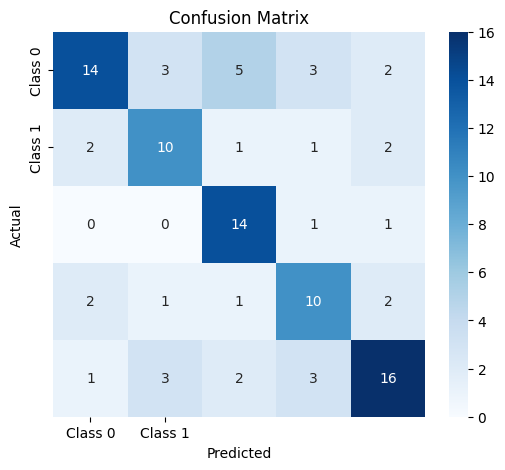

              precision    recall  f1-score   support

           0       0.74      0.52      0.61        27
           1       0.59      0.62      0.61        16
           2       0.61      0.88      0.72        16
           3       0.56      0.62      0.59        16
           4       0.70      0.64      0.67        25

    accuracy                           0.64       100
   macro avg       0.64      0.66      0.64       100
weighted avg       0.65      0.64      0.64       100



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict([X_test_img, X_test_tab])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # Only if y_test is one-hot encoded

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report (optional)
print(classification_report(y_true, y_pred))
